In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.optimize import root_scalar
from functools import partial


def integrate(func, a, b, n=1000):
    """Numerical integration using the trapezoidal rule."""
    x = np.linspace(a, b, n)
    y = np.fromiter((func(i) for i in x), dtype=np.float64, count=n)
    return np.trapezoid(y, x=x)

def double_integral(f_xy, x_min_of_y, x_max_of_y, y_min, y_max, grid_size=1001):
    # Integrate f(x,y) over the region defined by x_min_of_y, x_max_of_y, y_min, y_max
    return integrate(
        lambda y: integrate(f_xy, x_min_of_y(y), x_max_of_y(y), n=grid_size),
        y_min, y_max, n=grid_size
    )

def compute_area(x_min_of_y, x_max_of_y, y_min, y_max, grid_size=1001):
    # Compute the area of the region defined by x_min_of_y, x_max_of_y, y_min, y_max
    return integrate(
        lambda y: integrate(lambda x: 1, x_min_of_y(y), x_max_of_y(y), n=grid_size),
        y_min, y_max, n=grid_size
    )

def compute_area_vert(x_min, x_max, y_min_of_x, y_max_of_x, grid_size=1001):
    # Compute the area of the region defined by x_min, x_max, y_min_of_x, y_max_of_x
    return integrate(
        lambda x: integrate(lambda y: 1, y_min_of_x(x), y_max_of_x(x), n=grid_size),
        x_min, x_max, n=grid_size
    )

def inverse_integration(f, a, b, n=1000):
    """
    INVERSE FUNCTION TRICK

    Returns the result of
    integrate(f_inv, f(a), f(b))

    by instead computing 
    -integrate(f, a, b) + bf(b) - af(a)
    where f_inv is the inverse function of f.
    """
    if b > a:
        return -integrate(f, a, b) + b * f(b) - a * f(a)
    else:
        return integrate(f, b, a) + b * f(b) - a * f(a)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/andrewspears/.pyenv/versions/3.11.3/lib/python3.11/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _ARRAY_API not found

In [3]:
# TEMPLATE CLASS
class ContinuousPokerTemplate:
    @staticmethod
    def value_size(game_params, x):
        raise NotImplementedError("value_size method must be implemented in subclasses")
    
    @staticmethod
    def bluff_size(game_params, x):
        raise NotImplementedError("bluff_size method must be implemented in subclasses")

    @staticmethod
    def call_threshold(game_params, s):
        raise NotImplementedError("call_threshold method must be implemented in subclasses")
    
    @staticmethod
    def bluff_threshold(game_params):
        raise NotImplementedError("bluff_threshold method must be implemented in subclasses")
    
    @staticmethod
    def value_threshold(game_params):
        raise NotImplementedError("value_threshold method must be implemented in subclasses")
    
    @staticmethod
    def lose_showdown_payoff(s_integral, area):
            return -s_integral - 0.5* area
        
    @staticmethod
    def win_showdown_payoff(s_integral, area):
        return s_integral + 0.5* area
    
    @staticmethod
    def lose_ante_payoff(_, area):
        return -area*0.5
    
    @staticmethod
    def win_ante_payoff(_, area):
        return area*0.5

    @staticmethod  
    def outcome_to_payoff(outcome, s):
        if outcome == "Bluff_Called":
            return ContinuousPokerTemplate.lose_showdown_payoff(s, 1)
        elif outcome == "Bluff_Fold":
            return ContinuousPokerTemplate.win_ante_payoff(0, 1)
        elif outcome == "Value_Fold":
            return ContinuousPokerTemplate.win_ante_payoff(0, 1)
        elif outcome == "Value_Loses":
            return ContinuousPokerTemplate.lose_showdown_payoff(s, 1)
        elif outcome == "Value_Wins":
            return ContinuousPokerTemplate.win_showdown_payoff(s, 1)
        elif outcome == "Check_Wins":
            return ContinuousPokerTemplate.win_ante_payoff(0, 1)
        elif outcome == "Check_Loses":
            return ContinuousPokerTemplate.lose_ante_payoff(0, 1)
        else:
            raise ValueError(f"Unknown outcome: {outcome}")

    @classmethod
    def payoff_outcome(cls, game_params, x, y):
        if x < cls.bluff_threshold(game_params): # bluff
            s = cls.bluff_size(game_params, x)
            if y > cls.call_threshold(game_params, s):
                outcome = "Bluff_Called"
            else:
                outcome = "Bluff_Fold"
        elif x > cls.value_threshold(game_params): # value bet
            s = cls.value_size(game_params, x)
            if y < cls.call_threshold(game_params, s):
                outcome = "Value_Fold"
            elif y > x:
                outcome = "Value_Loses"
            else:
                outcome = "Value_Wins"
        else: 
            s=0
            if x > y:
                outcome = "Check_Wins" 
            else:
                outcome = "Check_Loses"
        return cls.outcome_to_payoff(outcome, s), outcome
            
    @classmethod
    def expected_payoff(cls, game_params, grid_size=1001):
        # numerically integrate the payoff(x, y) function over the grid [0,1] x [0,1]
        xs = np.linspace(0, 1, grid_size)
        ys = np.linspace(0, 1, grid_size)
        payoff_data = np.empty((grid_size, grid_size))
        for i in range(grid_size):
            for j in range(grid_size):
                try:
                    val, _ = cls.payoff_outcome(game_params, xs[i], ys[j])
                    payoff_data[i, j] = val if np.isfinite(val) else np.nan
                except:
                    payoff_data[i, j] = np.nan
        average_payoff = np.nanmean(payoff_data)
        return average_payoff
    
    @classmethod
    def total_payoff_for_outcome(cls, game_params, outcome, grid_size=1001):
        # numerically integrate the payoff(x, y) function over the grid [0,1] x [0,1], only where the outcome is outcome
        xs = np.linspace(0, 1, grid_size)
        ys = np.linspace(0, 1, grid_size)
        payoff_data = np.empty((grid_size, grid_size))
        for i in range(grid_size):
            for j in range(grid_size):
                try:
                    val, oc = cls.payoff_outcome(game_params, xs[i], ys[j])
                    if oc == outcome:
                        payoff_data[i, j] = val if np.isfinite(val) else np.nan
                    else:
                        payoff_data[i, j] = 0
                except:
                    payoff_data[i, j] = 0
        total_payoff = np.nanmean(payoff_data)
        return total_payoff

    @classmethod
    def generate_strategy_plot(cls, game_params, s_lim=None, grid_size=1001, save_path=None, title="Strategy Profile"):
        # find bluff and value sizes for each x
        X = np.linspace(0, 1, grid_size)
        bet_sizes = np.empty(grid_size)
        call_thresholds = np.empty(grid_size)
        for i, x in enumerate(X):
            if x < cls.bluff_threshold(game_params):
                s = cls.bluff_size(game_params, x)
            elif x > cls.value_threshold(game_params):
                s = cls.value_size(game_params, x)
            else:
                s = 0
            bet_sizes[i] = s

        # Add artificial points for perfect vertical lines
        adjusted_X = []
        adjusted_bet_sizes = []
        for i in range(len(bet_sizes) - 1):
            adjusted_X.append(X[i])
            adjusted_bet_sizes.append(bet_sizes[i])
            if bet_sizes[i] != 0 and bet_sizes[i + 1] == 0:
                adjusted_X.append(X[i])
                adjusted_bet_sizes.append(0)
            elif bet_sizes[i] == 0 and bet_sizes[i + 1] != 0:
                adjusted_X.append(X[i + 1])
                adjusted_bet_sizes.append(0)
        adjusted_X.append(X[-1])
        adjusted_bet_sizes.append(bet_sizes[-1])

        adjusted_X = np.array(adjusted_X)
        adjusted_bet_sizes = np.array(adjusted_bet_sizes)

        if s_lim is None:
            s_lim = np.max(adjusted_bet_sizes) * 1.1

        # find call thresholds for each s
        s_min = np.min(adjusted_bet_sizes[adjusted_bet_sizes > 0])
        s_max = np.max(adjusted_bet_sizes[adjusted_bet_sizes != np.inf])
        S = np.linspace(s_min, s_max, grid_size)
        for i, s in enumerate(S):
            call_thresholds[i] = cls.call_threshold(game_params, s)

        # plot
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot bet sizes as a function of x
        ax.plot(adjusted_X, adjusted_bet_sizes, label="Bet Function", color="red", linewidth=2)

        # Plot call thresholds as a function of s
        if s_min == s_max:
            # point instead of line
            ax.plot(call_thresholds, S, label="Call Threshold", color="blue", marker="o", markersize=5)
            ax.plot([call_thresholds[0], 1], [S[0], S[0]], color="blue", linestyle="--", alpha=0.3, linewidth=2, label="Call Region") 
        else:
            ax.plot(call_thresholds, S, label="Call Threshold", color="darkblue", linestyle="--", linewidth=2)
            ax.fill_betweenx(S, call_thresholds, np.ones_like(S), color="blue", alpha=0.3, label="Call Region")

        # ---- Labels, Legend, and Title ----
        ax.set_xlabel("Hand Strength", fontsize=12)
        ax.set_ylabel("Bet Size", fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True)

        # ---- Save or Show ----
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300)
        plt.show()


    @classmethod
    def generate_payoff_plot(cls, game_params, grid_size=1001, save_path=None, title="Payoffs by Hand Strength"):
        # ---- Parameters ----
        xs = np.linspace(0, 1, grid_size)
        ys = np.linspace(0, 1, grid_size)
        X, Y = np.meshgrid(xs, ys, indexing='ij')
        color_cap = 2

        # ---- Compute payoff grid ----
        payoff_data = np.empty((grid_size, grid_size))
        outcome_type = np.empty((grid_size, grid_size), dtype=object)
        for i in range(grid_size):
            for j in range(grid_size):
                try:
                    val, outcome = cls.payoff_outcome(game_params, xs[i], ys[j])
                    payoff_data[i, j] = val if np.isfinite(val) else np.nan
                    outcome_type[i, j] = outcome
                except:
                    payoff_data[i, j] = np.nan
        payoff_clipped = np.clip(payoff_data, -color_cap, color_cap)

        region_labels = [
            "Bluff_Called", "Bluff_Fold",
            "Value_Wins", "Value_Loses", "Value_Fold",
            "Check_Wins", "Check_Loses"
        ]

        # ---- Plot heatmap with region contours and labels ----
        fig, ax = plt.subplots(figsize=(7, 7))
        c = ax.imshow(
            payoff_clipped.T,
            extent=[0, 1, 0, 1],
            origin='lower',
            cmap='coolwarm',
            norm=TwoSlopeNorm(vmin=-color_cap, vcenter=0, vmax=color_cap)
        )
        cbar = fig.colorbar(c, ax=ax, shrink=0.9)
        cbar.set_label("Bettor Payoff", fontsize=12)
        cbar.set_ticks([-color_cap, 0, color_cap])
        cbar.set_ticklabels([f"<-{color_cap}", "0", f">{color_cap}"])

        for label in region_labels:
            mask = outcome_type == label
            if np.any(mask):
                ax.contour(
                    X, Y, mask.astype(float),
                    levels=[0.5],
                    colors='white',
                    linewidths=1.5
                )
                region_center = np.argwhere(mask)
                if len(region_center) > 0:
                    center_x, center_y = region_center.mean(axis=0)
                    ax.text(
                        xs[int(center_x)], ys[int(center_y)],
                        label.replace("_", " "),
                        color="white",
                        fontsize=10,
                        ha="center",
                        va="center",
                        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
                    )

        ax.set_xlabel("x (bettor hand strength)")
        ax.set_ylabel("y (caller hand strength)")
        ax.set_title(title)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300)
        plt.show()

In [4]:
# FIXED BET CONTINUOUS POKER 

class CP(ContinuousPokerTemplate):
    # ---- Threshold functions ----
       
    def bluff_threshold(game_params):
        B = game_params['B']
        return 2 * B / ((1 + 2 * B) * (4 + 2 * B))

    def value_threshold(game_params):
        B = game_params['B']
        return (2 + 8 * B + 4 * B**2) / ((1 + 2 * B) * (4 + 2 * B))

    def call_threshold(game_params, s):
        return (2 * s * (3 + 2 * s)) / ((1 + 2 * s) * (4 + 2 * s))

    def bluff_size(game_params, x):
        return game_params['B']

    def value_size(game_params, x):
        return game_params['B']

In [5]:
# NO LIMIT CONTINUOUS POKER
class NLCP(ContinuousPokerTemplate):
    def bluff_threshold(game_params):
        return 1 / 7

    def value_threshold(game_params):
        return 4 / 7

    def call_threshold(game_params, s):
        return 1 - 6 / (7 * (1 + s))

    def bluff_size(game_params, x):
        return (1 / (7 * x)**(1/3)) - 1

    def value_size(game_params, x):
        return np.sqrt(3 / (7 * (1 - x))) - 1

In [66]:
# L, U LIMIT CONTINUOUS POKER

class LCP_utils:
    _cache = {}
    _last_game_params = None

    @staticmethod
    def clear_cache():
        LCP_utils._cache.clear()
        LCP_utils._last_game_params = None

    @staticmethod
    def check_and_clear_cache(game_params):
        if LCP_utils._last_game_params != game_params:
            LCP_utils.clear_cache()
            LCP_utils._last_game_params = game_params

    @staticmethod
    def compute_A0(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A0' not in LCP_utils._cache:
            LCP_utils._cache['A0'] = U**2 + 3 * U + 3
        return LCP_utils._cache['A0']

    @staticmethod
    def compute_A1(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A1' not in LCP_utils._cache:
            LCP_utils._cache['A1'] = 7 * U**3 + 21 * U**2 + 21 * U + 6
        return LCP_utils._cache['A1']

    @staticmethod
    def compute_A2(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A2' not in LCP_utils._cache:
            LCP_utils._cache['A2'] = 6 * U**3 + 18 * U**2 + 18 * U + 5
        return LCP_utils._cache['A2']

    @staticmethod
    def compute_A3(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A3' not in LCP_utils._cache:
            LCP_utils._cache['A3'] = 7 * U**3 + 21 * U**2 + 18 * U + 3
        return LCP_utils._cache['A3']

    @staticmethod
    def compute_A4(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A4' not in LCP_utils._cache:
            A1 = LCP_utils.compute_A1(game_params)
            A2 = LCP_utils.compute_A2(game_params)
            LCP_utils._cache['A4'] = 3 * A1 * L**2 + 3 * A1 * L + A1 + A2 * L**3
        return LCP_utils._cache['A4']

    @staticmethod
    def compute_A5(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'A5' not in LCP_utils._cache:
            A0 = LCP_utils.compute_A0(game_params)
            LCP_utils._cache['A5'] = 3 * A0 * L**2 * U + 3 * A0 * L * U + A0 * U - L**3
        return LCP_utils._cache['A5']

    @staticmethod
    def compute_x0(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x0' not in LCP_utils._cache:
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x0'] = (3 * (L + 1)**3 * U) / A4
        return LCP_utils._cache['x0']

    @staticmethod
    def compute_x1(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x1' not in LCP_utils._cache:
            A0 = LCP_utils.compute_A0(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x1'] = (3 * A0 * L * U + A0 * U - L**3 - 3 * L**2) / A4
        return LCP_utils._cache['x1']

    @staticmethod
    def compute_x2(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x2' not in LCP_utils._cache:
            A5 = LCP_utils.compute_A5(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x2'] = A5 / A4
        return LCP_utils._cache['x2']

    @staticmethod
    def compute_x3(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x3' not in LCP_utils._cache:
            A2 = LCP_utils.compute_A2(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x3'] = (A2 * L**3 + 3 * A2 * L**2 + 3 * L * (5 * U**3 + 15 * U**2 + 15 * U + 4) +
                                        4 * U**3 + 12 * U**2 + 12 * U + 3) / A4
        return LCP_utils._cache['x3']

    @staticmethod
    def compute_x4(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x4' not in LCP_utils._cache:
            A1 = LCP_utils.compute_A1(game_params)
            A2 = LCP_utils.compute_A2(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x4'] = (3 * A1 * L**2 + A2 * L**3 + 3 * A2 * L + 4 * U**3 + 12 * U**2 + 12 * U + 3) / A4
        return LCP_utils._cache['x4']

    @staticmethod
    def compute_x5(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'x5' not in LCP_utils._cache:
            A3 = LCP_utils.compute_A3(game_params)
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['x5'] = (3 * A3 * L**2 + 3 * A3 * L + A3 + L**3 * (6 * U**3 + 18 * U**2 + 15 * U + 2)) / A4
        return LCP_utils._cache['x5']

    @staticmethod
    def compute_b0(game_params):
        L, U = game_params['L'], game_params['U']
        LCP_utils.check_and_clear_cache(game_params)
        if 'b0' not in LCP_utils._cache:
            A4 = LCP_utils.compute_A4(game_params)
            LCP_utils._cache['b0'] = -(L + 1)**3 / A4
        return LCP_utils._cache['b0']
    
    @staticmethod
    def v_of_s(s, x2):
        return (x2 + 2*s**2 + 4*s + 1)/(2*(1 + s)**2)
    
    @staticmethod
    def b_of_s(s, b0, x2):
        return b0 - ((1 + 3*s)*(x2 - 1)) / (6*(1 + s)**3)
    
    @staticmethod
    def inverse_c(y, x2):
        # caller calls when y>c(s). 
        # Instead, find c_inv such that we call when s < c_inv(y)
        # x = v(s) < v(c_inv(y))
        # so call when x < v(c_inv(y))
        # Now we can distinguish fold/call regions with only y and x. 
        return (x2-y)/(y-1)
    
    @staticmethod
    def inverse_b(x, b0, x2, bracket=(1e-6, 100)):
        # Solve b(s) = x for s
        f = lambda s: LCP_utils.b_of_s(s, b0, x2) - x
        sol = root_scalar(f, bracket=bracket, method='brentq')
        if sol.converged:
            return sol.root
        else:
            raise ValueError("Root finding did not converge")

    @staticmethod
    def inverse_v(x, x2):
        # Solve v(s) = x for s
        return -1 - np.sqrt( (4*x-4) * (-2 + 2*x2) ) / (4*x-4)
    
    # integrate s over x and y, but we have x=v(s)
    # for each region:
    # break it into horizontal strips. 
    # for each strip, we have the left endpoint and right endpoint from x and y.
    # integrate s(x) over the strip using the inverse integration trick with x=v(s).
    # integrate the strips over y.4

    class Region:
        def point_in_region(self, x, y):
            in_x_bounds = self.x_min_of_y(y) <= x < self.x_max_of_y(y)
            in_y_bounds = self.y_min <= y < self.y_max
            return in_x_bounds and in_y_bounds
        
        def compute_area(self, grid_size=101):
            return compute_area(self.x_min_of_y, self.x_max_of_y, self.y_min, self.y_max, grid_size)
        
        def compute_s_integral(self, grid_size=101):
            raise NotImplementedError("compute_s_integral method must be implemented in subclasses")
        
        def compute_payoff(self, grid_size=101):
            area = self.compute_area(grid_size=grid_size)
            s_integral = self.compute_s_integral(grid_size=grid_size)
            return self.payoff_func(s_integral, area)

    class InverseRegion(Region):
        def __init__(self, s_left_of_y, s_right_of_y, y_min, y_max, payoff_func, x_of_s):
            self.s_left_of_y = s_left_of_y
            self.s_right_of_y = s_right_of_y
            self.x_min_of_y = lambda y: x_of_s(self.s_left_of_y(y))
            self.x_max_of_y = lambda y: x_of_s(self.s_right_of_y(y))
            self.y_min = y_min
            self.y_max = y_max
            self.payoff_func = payoff_func
            self.x_of_s = x_of_s

        def compute_s_integral(self, grid_size=101):
            integrand = lambda y: inverse_integration(self.x_of_s, self.s_left_of_y(y), self.s_right_of_y(y), grid_size)
            return integrate(integrand, self.y_min, self.y_max, grid_size)
        
    class VariableRegion(Region):
        def __init__(self, x_min_of_y, x_max_of_y, y_min, y_max, payoff_func, s_of_xy):
            self.x_min_of_y = x_min_of_y
            self.x_max_of_y = x_max_of_y
            self.y_min = y_min
            self.y_max = y_max
            self.payoff_func = payoff_func
            self.s_of_xy = s_of_xy

        def compute_s_integral(self, grid_size=101):
            integrand = lambda y: integrate(lambda x: self.s_of_xy(x, y), self.x_min_of_y(y), self.x_max_of_y(y), grid_size)
            return integrate(integrand, self.y_min, self.y_max, grid_size)
    
        
    class ConstRegion(Region):
        def __init__(self, x_min_of_y, x_max_of_y, y_min, y_max, payoff_func, s):
            self.x_min_of_y = x_min_of_y
            self.x_max_of_y = x_max_of_y
            self.y_min = y_min
            self.y_max = y_max
            self.payoff_func = payoff_func
            self.s = s

        def compute_s_integral(self, grid_size=101):
            area = self.compute_area(grid_size=grid_size)
            s_integral = self.s * area
            return s_integral
    

class LCP(ContinuousPokerTemplate):
    def call_threshold(game_params, s):
        x2 = LCP_utils.compute_x2(game_params)
        return (x2+s)/(1+s)
    
    def bluff_threshold(game_params):
        return LCP_utils.compute_x2(game_params)
    
    def value_threshold(game_params):
        return LCP_utils.compute_x3(game_params)
    
    def bluff_size(game_params, x):
        L = game_params['L']
        U = game_params['U']
        x0 = LCP_utils.compute_x0(game_params)
        x1 = LCP_utils.compute_x1(game_params)
        x2 = LCP_utils.compute_x2(game_params)
        b0 = LCP_utils.compute_b0(game_params)
        if x < x0:
            return U
        elif x < x1:
            return LCP_utils.inverse_b(x, b0, x2)
        else:
            return L
        
    def value_size(game_params, x):
        L = game_params['L']
        U = game_params['U']
        x2 = LCP_utils.compute_x2(game_params)
        x4 = LCP_utils.compute_x4(game_params)
        x5 = LCP_utils.compute_x5(game_params)
        if x < x4:
            return L
        elif x < x5:
            return LCP_utils.inverse_v(x, x2)
        else:
            return U
        
    @classmethod
    def expected_payoff_symbolic(cls, game_params):
        '''
        Compute the expected payoff using a reduced formula of just L and U.
        Much faster than the numerical integration.
        Formula found using mathematica.
        '''
        L, U = game_params['L'], game_params['U']
        numerator = -(
            L**6 * (53 + 234*U + 378*U**2 + 270*U**3 + 72*U**4)
            + 6*L*U * (-30 - 111*U - 108*U**2 + 27*U**3 + 90*U**4 + 35*U**5)
            + U * (-18 - 45*U + 36*U**2 + 183*U**3 + 174*U**4 + 53*U**5)
            - 2*L**3 * (-81 + 51*U + 1203*U**2 + 2321*U**3 + 1620*U**4 + 288*U**5 - 72*U**6)
            - 6*L**5 * (-33 - 123*U - 132*U**2 + 5*U**3 + 87*U**4 + 42*U**5 + 3*U**6)
            - 3*L**4 * (-90 - 216*U + 171*U**2 + 862*U**3 + 825*U**4 + 258*U**5 + 3*U**6)
            + 3*L**2 * (12 - 138*U - 705*U**2 - 1020*U**3 - 465*U**4 + 102*U**5 + 97*U**6)
        )

        denominator = 2*(
            (6 + 21*U + 21*U**2 + 7*U**3
            + L**3 * (5 + 18*U + 18*U**2 + 6*U**3)
            + 3*L * (6 + 21*U + 21*U**2 + 7*U**3)
            + 3*L**2 * (6 + 21*U + 21*U**2 + 7*U**3))**2
        )

        return numerator / denominator
        
    @classmethod
    def get_regions(cls, game_params):
        bth = cls.bluff_threshold(game_params)
        vth = cls.value_threshold(game_params)
        x2 = LCP_utils.compute_x2(game_params)
        b0 = LCP_utils.compute_b0(game_params)
        b = lambda s : LCP_utils.b_of_s(s, b0, x2)
        v = lambda s : LCP_utils.v_of_s(s, x2)
        c = lambda s : LCP.call_threshold(game_params, s)
        c_inv = lambda y : LCP_utils.inverse_c(y, x2)
        U = game_params['U']
        L = game_params['L']

        # ----- Bluff Called -----
        # r0: x < b(U), y > c(U), s = U
        r0 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: 0,
            x_max_of_y=lambda y: b(U),
            y_min=c(U),
            y_max=1,
            payoff_func=ContinuousPokerTemplate.lose_showdown_payoff,
            s=U
        )

        # r1: b(U) < x < b(L), y > c(U), b(s) = x
        r1 = LCP_utils.InverseRegion(
            s_left_of_y=lambda y: U,
            s_right_of_y=lambda y: L,
            y_min=c(U),
            y_max=1,
            payoff_func=ContinuousPokerTemplate.lose_showdown_payoff,
            x_of_s=b
        )

        # r2: b(c_inv(y)) < x < b(L), c(L) < y < c(U), b(s) = x
        r2 = LCP_utils.InverseRegion(
            s_left_of_y=lambda y: c_inv(y),
            s_right_of_y=lambda y: L,
            y_min=c(L),
            y_max=c(U),
            payoff_func=ContinuousPokerTemplate.lose_showdown_payoff,
            x_of_s=b
        )

        # r3: b(L) < x < bth, y > c(L), s = L
        r3 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: b(L),
            x_max_of_y=lambda y: bth,
            y_min=c(L),
            y_max=1,
            payoff_func=ContinuousPokerTemplate.lose_showdown_payoff,
            s=L
        )

        # ---- Bluff Fold -----
        # r4: x < b(U), c(L) < y < c(U)
        r4 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: 0,
            x_max_of_y=lambda y: b(U),
            y_min=c(L),
            y_max=c(U),
            payoff_func=ContinuousPokerTemplate.win_ante_payoff,
            s=0 # s is irrelevant
        )

        # r5: b(U) < x < b(c_inv(y)), c(L) < y < c(U)
        r5 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: b(U),
            x_max_of_y=lambda y: b(c_inv(y)),
            y_min=c(L),
            y_max=c(U),
            payoff_func=ContinuousPokerTemplate.win_ante_payoff,
            s=0  # s is irrelevant
        )

        # r6: x < bth, y < c(L)
        r6 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: 0,
            x_max_of_y=lambda y: bth,
            y_min=0,
            y_max=c(L),
            payoff_func=ContinuousPokerTemplate.win_ante_payoff,
            s=0  # s is irrelevant
        )

        # ----- Check Loses -----
        # r7: bth < x < vth, y > vth
        r7 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: bth,
            x_max_of_y=lambda y: vth,
            y_min=vth,
            y_max=1,
            payoff_func=ContinuousPokerTemplate.lose_ante_payoff,
            s=0 
        )
            
        # r8: bth < x < y, bth < y < vth -- PERFECTLY CANCELS WITH r9
        
        # ----- Check Wins -----
        # r9: y < x < vth, bth < y < vth -- PERFECTLY CANCELS WITH r8
        
        # r10: bth < x < vth, y < bth
        r10 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: bth,
            x_max_of_y=lambda y: vth,
            y_min=0,
            y_max=bth,
            payoff_func=ContinuousPokerTemplate.win_ante_payoff,
            s=0  # No specific s value for this region
        )

        # ----- Value Loses -----
        # r11: vth < x < v(L), y > v(L), s=L
        r11 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: vth,
            x_max_of_y=lambda y: v(L),
            y_min=v(L),
            y_max=1,
            payoff_func=ContinuousPokerTemplate.lose_showdown_payoff,
            s=L
        )
        
        # r12: vth < x < y, vth < y < v(L), s=L -- PERFECTLY CANCELS WITH r16
        
        # r13: v(L) < x < v(U), v(U) < y < 1, s=v_inv(x)
        r13 = LCP_utils.VariableRegion(
            x_min_of_y=lambda y: v(L),
            x_max_of_y=lambda y: v(U),
            y_min=v(U),
            y_max=1,
            payoff_func=ContinuousPokerTemplate.lose_showdown_payoff,
            s_of_xy=lambda x, y : LCP_utils.inverse_v(x, x2)
        )
            
        # r14: v(L) < x < y, v(L) < y < v(U), x=v_inv(s) 
        r14 = LCP_utils.VariableRegion(
            x_min_of_y=lambda y: v(L),
            x_max_of_y=lambda y: y,
            y_min=v(L),
            y_max=v(U),
            payoff_func=ContinuousPokerTemplate.lose_showdown_payoff,
            s_of_xy=lambda x, y : LCP_utils.inverse_v(x, x2)
        )

        # r15: v(U) < x < y, y > v(U), s=U -- PERFECTLY CANCELS WITH r21
    
        # ----- Value Wins -----
        # r16: y < x < v(L), vth < y < v(L), s=L -- PERFECTLY CANCELS WITH r12

        # r17: vth < x < v(L), c(L) < y < vth, s=L
        r17 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: vth,
            x_max_of_y=lambda y: v(L),
            y_min=c(L),
            y_max=vth,
            payoff_func=ContinuousPokerTemplate.win_showdown_payoff,
            s=L
        )

        # r18: y < x < v(U), v(L) < y < v(U), s=v_inv(x)
        r18 = LCP_utils.VariableRegion(
            x_min_of_y=lambda y: y,
            x_max_of_y=lambda y: v(U),
            y_min=v(L),
            y_max=v(U),
            payoff_func=ContinuousPokerTemplate.win_showdown_payoff,
            s_of_xy=lambda x, y : LCP_utils.inverse_v(x, x2)
        )

        # r19: v(L) < x < v(U), c(U) < y < v(L), v(s)=x
        r19 = LCP_utils.InverseRegion(
            s_left_of_y=lambda y: L,
            s_right_of_y=lambda y: U,
            y_min=c(U),
            y_max=v(L),
            payoff_func=ContinuousPokerTemplate.win_showdown_payoff,
            x_of_s=v
        )

        # r20: v(L) < x < v(c_inv(y)), c(L) < y < c(U), v(s)=x
        r20 = LCP_utils.InverseRegion(
            s_left_of_y=lambda y: L,
            s_right_of_y=lambda y: c_inv(y),
            y_min=c(L),
            y_max=c(U),
            payoff_func=ContinuousPokerTemplate.win_showdown_payoff,
            x_of_s=v
        )

        # r21: y < x, y > v(U), s=U -- PERFECTLY CANCELS WITH r15

        # r22: x > v(U), c(U) < y < v(U), s=U
        r22 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: v(U),
            x_max_of_y=lambda y: 1,
            y_min=c(U),
            y_max=v(U),
            payoff_func=ContinuousPokerTemplate.win_showdown_payoff,
            s=U
        )

        # ------ Value Fold -----
        # r23: v(c_inv(y)) < x, c(L) < y < c(U)
        r23 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: v(c_inv(y)),
            x_max_of_y=lambda y: 1,
            y_min=c(L),
            y_max=c(U),
            payoff_func=ContinuousPokerTemplate.win_ante_payoff,
            s=0  # s is irrelevant
        )

        # r24: x > vth, y < c(L)
        r24 = LCP_utils.ConstRegion(
            x_min_of_y=lambda y: vth,
            x_max_of_y=lambda y: 1,
            y_min=0,
            y_max=c(L),
            payoff_func=ContinuousPokerTemplate.win_ante_payoff,
            s=0  # s is irrelevant
        )

        regions = {
            0: r0, 1: r1, 2: r2, 3: r3, 4: r4, 5: r5, 6: r6,
            7: r7, 10: r10,
            11: r11, 13: r13, 14: r14,
            17: r17, 18: r18, 19: r19,
            20: r20, 22: r22,
            23: r23, 24: r24
        }

        return regions

    @classmethod
    def expected_payoff_by_region(cls, game_params, grid_size=1001):
        '''
        Compute the integral over the square by regions to avoid ever solving for v_inv and b_inv.
        Not any faster than the numerical integration, but proof of concept for a symbolic integration.
        '''
        regions = cls.get_regions(game_params)

        total_payoff = 0
        for i, r in regions.items():
            payoff = r.compute_payoff() 
            # print(f"Payoff for region {i}: {payoff}")
            total_payoff+= payoff
        return total_payoff

In [59]:
x2 = LCP_utils.compute_x2({'L': 0.1, 'U': 0.9})
LCP_utils.inverse_v(0.8, x2)

np.float64(0.4794178414947601)

In [70]:
game_params = {'L': 0.5, 'U': 1.5}
grid_size = 1001

real_expected = LCP.expected_payoff(game_params)
expected = LCP.expected_payoff_by_region(game_params, grid_size=grid_size)
print(f"Real expected payoff: {real_expected}")
print(f"Expected payoff: {expected}")

# FOR COMPARISON:

# TEST REGIONS ARE DISJOINT AND COVER THE SQUARE
# regions = LCP.get_regions(game_params)

# # Create a grid over the unit square
# x_vals = np.linspace(0, 1, grid_size)[:-1]
# y_vals = np.linspace(0, 1, grid_size)[:-1]
# X, Y = np.meshgrid(x_vals, y_vals)

# # Collect points for each region
# region_points = {region_id: [] for region_id in regions.keys()}
# uncovered_points = []

# region_payoffs = {region_id: 0 for region_id in regions.keys()}
# region_areas = {region_id: 0 for region_id in regions.keys()}

# # Check each point in the grid
# for xi, yi in zip(X.flatten(), Y.flatten()):
#     in_regions = [region_id for region_id, region in regions.items() if region.point_in_region(xi, yi)]
#     if len(in_regions) == 1:  # Point is in exactly one region
#         region_points[in_regions[0]].append((xi, yi))

#         payoff, _ = LCP.payoff_outcome(game_params, xi, yi)
#         region_payoffs[in_regions[0]] += payoff
#         region_areas[in_regions[0]] += 1
#     elif len(in_regions) == 0:  # Point is not in any region
#         uncovered_points.append((xi, yi))
#     else:  # Point is in multiple regions
#         raise ValueError(f"Point ({xi}, {yi}) is in multiple regions: {in_regions}")

# # Plot points for each region
# plt.figure(figsize=(10, 8))
# colors = plt.cm.tab20(np.linspace(0, 1, len(regions)))  # Generate distinct colors for regions

# for region_id, points in region_points.items():
#     if points:
#         points = np.array(points)
#         plt.scatter(points[:, 0], points[:, 1], color=colors[region_id % len(colors)], label=f'Region {region_id}', s=10)
#     region_areas[region_id] /= (grid_size - 1)**2  # Normalize area to unit square
#     region_payoffs[region_id] /= (grid_size - 1)**2  # Normalize payoff to unit square
#     print(f"Region {region_id}: Area = {region_areas[region_id]}, Payoff = {region_payoffs[region_id]}")

# print("Total  payoff:", sum(region_payoffs.values()))
# print("Total area:", sum(region_areas.values()))

# # Plot uncovered points in red
# if uncovered_points:
#     uncovered_points = np.array(uncovered_points)
#     plt.scatter(uncovered_points[:, 0], uncovered_points[:, 1], color='red', label='Uncovered Points', s=10)

# # Add labels, legend, and grid
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Points Covered by Regions')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid()
# plt.tight_layout()
# plt.show()

# # 19, 20, 23, wrong


Real expected payoff: 0.06525755189877096
Expected payoff: 0.06515168471517196


In [60]:
game_params = {'L': 0.5, 'U': 1.5}
L = game_params['L']
U = game_params['U']
c = lambda s: LCP.call_threshold(game_params, s)
x2 = LCP_utils.compute_x2(game_params)
v = lambda s: LCP_utils.v_of_s(s, x2)
inverse_v = lambda x: LCP_utils.inverse_v(x, x2)

r19_inverse = LCP_utils.InverseRegion(
    s_left_of_y=lambda y: L,
    s_right_of_y=lambda y: U,
    y_min=c(U),
    y_max=v(L),
    payoff_func=ContinuousPokerTemplate.win_showdown_payoff,
    x_of_s=v
)

r19_variable = LCP_utils.VariableRegion(
    x_min_of_y=lambda y: v(L),
    x_max_of_y=lambda y: v(U),
    y_min=c(U),
    y_max=v(L),
    payoff_func=ContinuousPokerTemplate.win_showdown_payoff,
    s_of_xy=lambda x, y: LCP_utils.inverse_v(x, x2)
)

print("r19 inverse area:", r19_inverse.compute_area())
print("r19 variable area:", r19_variable.compute_area())
print("r19 inverse payoff:", r19_inverse.compute_payoff())
print("r19 variable payoff:", r19_variable.compute_payoff())
print("r19 inverse s integral:", r19_inverse.compute_s_integral())
print("r19 variable s integral:", r19_variable.compute_s_integral())


print("regular integral: ", integrate(inverse_v, v(L), v(U), n=1001))
print("inverse integral: ", inverse_integration(v, L, U, n=1001))


r19 inverse area: 0.01912404721739061
r19 variable area: 0.01912404721739061
r19 inverse payoff: 0.026295567532120957
r19 variable payoff: 0.026295842569946885
r19 inverse s integral: 0.016733543923425652
r19 variable s integral: 0.01673381896125158
regular integral:  0.10822884462004932
inverse integral:  0.10822884353140078


In [61]:
print(v(1))
print(inverse_v(v(0.8)))

0.891288008933173
0.8


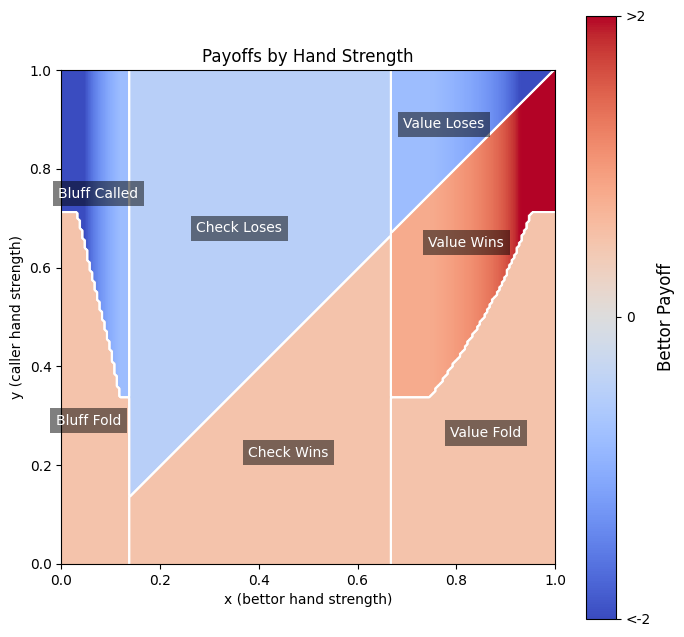

In [ ]:
# CP.payoff_outcome(game_params={'B':1}, x=0.5, y=0.5)
# LCP.generate_payoff_plot(game_params={'L':0.3, 'U': 2}, grid_size=201)
# CP.generate_strategy_plot(game_params={'B': 0.5}, grid_size=21)
# LCP.generate_strategy_plot(game_params={'L': 0.3, "U":1}, grid_size=10001)
# NLCP.generate_strategy_plot({})
# LCP.value_size(game_params={'L': 0.5, "U":2}, x=0.65)
# LCP.inverse_v(x, x2)

In [68]:
from tqdm.notebook import tqdm

# EXPECTED PAYOFF OVER L, U GRID
cap = 10000
grid_size = 51

# Create a grid of L and U values on a logarithmic scale
Ls = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
Us = np.logspace(-np.log10(cap), np.log10(cap), grid_size)
# Ls = np.linspace(0, cap, grid_size)
# Us = np.linspace(0, cap, grid_size)
L_grid, U_grid = np.meshgrid(Ls, Us)

# Initialize an array to store expected payoffs
payoff_grid = np.full_like(L_grid, np.nan, dtype=np.float64)

# Compute expected payoff for each pair (L, U) where L < U
for i in tqdm(range(L_grid.shape[0]), desc="Rows"):
    for j in range(L_grid.shape[1]):
        L = L_grid[i, j]
        U = U_grid[i, j]
        if L <= U:
            params = {"L": L, "U": U}
            LCP_utils.clear_cache()
            avg_payoff = LCP.expected_payoff_by_region(params)
            payoff_grid[i, j] = avg_payoff


Rows:   0%|          | 0/51 [00:00<?, ?it/s]

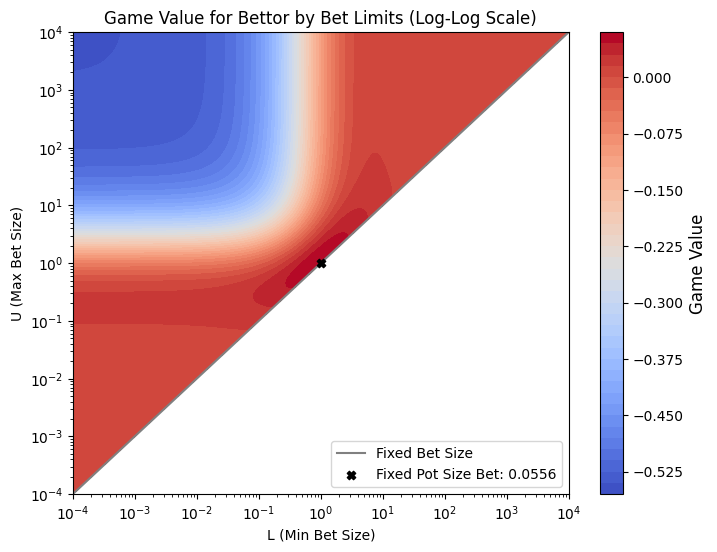

In [8]:
# Plot the heatmap on a log-log scale
plt.figure(figsize=(8, 6))
contour = plt.contourf(Ls, Us, payoff_grid, levels=50, cmap="coolwarm", vmax=np.nanmax(payoff_grid))

# Add a diagonal line from (0, 0) to (cap, cap)
plt.plot([1/cap, cap], [1/cap, cap], color="grey", linestyle="-", label="Fixed Bet Size")
# plt.plot([0, cap], [0, cap], color="grey", linestyle="-", label="Fixed Bet Size")

# Add a point at (1,1) labeled with the value there, ensuring it is on the line
value_at_point = payoff_grid[np.argmin(np.abs(Ls - 1)), np.argmin(np.abs(Us - 1))]
plt.scatter(1, 1, marker="X", color="black", label=f"Fixed Pot Size Bet: {value_at_point:.4f}", zorder=5)
plt.legend(loc="lower right")  # Move the legend to the bottom right

# Add a color bar with the same colormap
cbar = plt.colorbar(contour)
cbar.set_label("Game Value", fontsize=12)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("L (Min Bet Size)")
plt.ylabel("U (Max Bet Size)")
plt.title("Game Value for Bettor by Bet Limits (Log-Log Scale)")
# plt.title("Game Value for Bettor by Bet Limits")
plt.show()


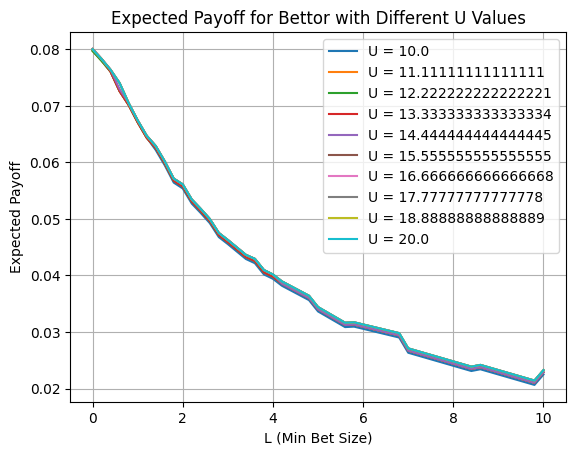

In [13]:
# Define the values of U to iterate over
U_values = np.linspace(10, 20, 10)
L = np.linspace(0, np.min(U_values), 51)

# Plot the expected payoff for each U
for U in U_values:
    payoff = np.empty_like(L)
    for i, l in enumerate(L):
        params = {"L": l, "U": U}
        LCP_utils.clear_cache()
        payoff[i] = LCP.expected_payoff(params, grid_size=51)
    plt.plot(L, payoff, label=f"U = {U}")

# Add labels, title, legend, and grid
plt.xlabel("L (Min Bet Size)")
plt.ylabel("Expected Payoff")
plt.title("Expected Payoff for Bettor with Different U Values")
plt.legend()
plt.grid()
plt.show()

/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_30178/1454305013.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


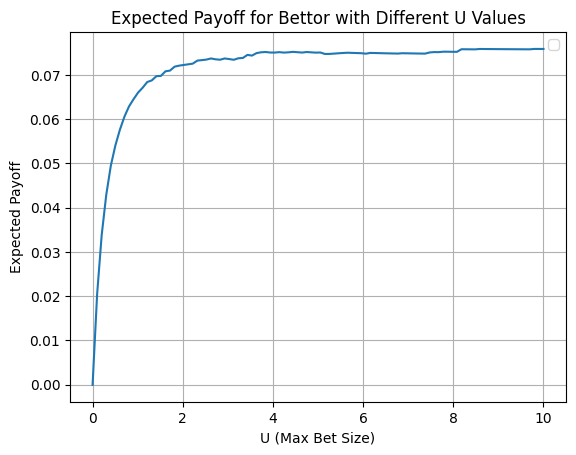

In [38]:

L = 0
# Us = np.logspace(-2, 2, 100)
Us = np.linspace(0, 10, 100)

# Plot the expected payoff for each U
payoffs = np.empty_like(Us)
for i, U in enumerate(Us):
    params = {"L": L, "U": U}
    LCP_utils.clear_cache()
    payoffs[i] = LCP.expected_payoff(params, grid_size=101)
plt.plot(Us, payoffs)

# Add labels, title, legend, and grid
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("U (Max Bet Size)")
plt.ylabel("Expected Payoff")
plt.title("Expected Payoff for Bettor with Different U Values")
plt.legend()
plt.grid()
plt.show()